In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../utils/')
import feedforward_robust as ffr
import ipdb
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

W0927 08:51:50.727205 4424283584 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

### Trying out different corruptions 

In [5]:
paths = np.load("paths_regularized.npy", allow_pickle = True)

In [6]:
paths

array(defaultdict(<class 'list'>, {'non_robust': ['weights/model_375.ckpt', 'weights/model_381.ckpt', 'weights/model_387.ckpt', 'weights/model_393.ckpt', 'weights/model_399.ckpt', 'weights/model_405.ckpt', 'weights/model_411.ckpt', 'weights/model_417.ckpt'], 'l1': ['weights/model_376.ckpt', 'weights/model_382.ckpt', 'weights/model_388.ckpt', 'weights/model_394.ckpt', 'weights/model_400.ckpt', 'weights/model_406.ckpt', 'weights/model_412.ckpt', 'weights/model_418.ckpt'], 'op': ['weights/model_377.ckpt', 'weights/model_383.ckpt', 'weights/model_389.ckpt', 'weights/model_395.ckpt', 'weights/model_401.ckpt', 'weights/model_407.ckpt', 'weights/model_413.ckpt', 'weights/model_419.ckpt'], 'trace_first': ['weights/model_378.ckpt', 'weights/model_384.ckpt', 'weights/model_390.ckpt', 'weights/model_396.ckpt', 'weights/model_402.ckpt', 'weights/model_408.ckpt', 'weights/model_414.ckpt', 'weights/model_420.ckpt'], 'trace_all': ['weights/model_379.ckpt', 'weights/model_385.ckpt', 'weights/model_391

In [7]:
paths.item()

defaultdict(list,
            {'non_robust': ['weights/model_375.ckpt',
              'weights/model_381.ckpt',
              'weights/model_387.ckpt',
              'weights/model_393.ckpt',
              'weights/model_399.ckpt',
              'weights/model_405.ckpt',
              'weights/model_411.ckpt',
              'weights/model_417.ckpt'],
             'l1': ['weights/model_376.ckpt',
              'weights/model_382.ckpt',
              'weights/model_388.ckpt',
              'weights/model_394.ckpt',
              'weights/model_400.ckpt',
              'weights/model_406.ckpt',
              'weights/model_412.ckpt',
              'weights/model_418.ckpt'],
             'op': ['weights/model_377.ckpt',
              'weights/model_383.ckpt',
              'weights/model_389.ckpt',
              'weights/model_395.ckpt',
              'weights/model_401.ckpt',
              'weights/model_407.ckpt',
              'weights/model_413.ckpt',
              'weights/model_419.c

In [8]:
non_rob_list = paths.item()['non_robust']

In [31]:
def load_many_models_regular(weights_path):
    
    model_list = []
    sess_list = []
    for path in weights_path:
        config = {}
        config['eps_train'] = 0.1
        config['eps_test'] = 0.1
        config['tensorboard_dir'] = "tb/"
        config['weights_dir'] = "weights_new/"

        config['load_counter'] = path
        config['write_counter'] = counter
        config['sigma'] = tf.nn.relu
        config['epochs'] = 10
        config['reg_op'] = 0.0
        config['reg_l1'] = 0.0
        config['reg_trace_first'] = 0.0
        config['reg_trace_all'] = 0.0

        config['lr'] = 3e-4

        config['scope_name'] = "model_non_robust"
        config['should_load'] = True
        config['logger'] = logger
        model, sess, path = regular_training(config)
        model_list.append(model)
        sess_list.append(sess)
    return model_list, sess_list

In [56]:
def load_many_models_adv(weights_path):
    
    model_list = []
    sess_list = []
    for path in weights_path:
        config = {}
        config['eps_train'] = 0.1
        config['eps_test'] = 0.1
        config['tensorboard_dir'] = "tb/"
        config['weights_dir'] = "weights_new/"

        config['load_counter'] = path
        config['write_counter'] = counter
        config['sigma'] = tf.nn.relu
        config['epochs'] = 10
        config['reg_op'] = 0.0
        config['reg_l1'] = 0.0
        config['reg_trace_first'] = 0.0
        config['reg_trace_all'] = 0.0

        config['lr'] = 3e-4

        config['scope_name'] = "model_robust"
        config['should_load'] = True
        config['logger'] = logger
        model, sess, path = regular_training(config)
        model_list.append(model)
        sess_list.append(sess)
    return model_list, sess_list

In [51]:
def get_complexitites_many_models_reg(model_list, sess_list, x_test, y_test):
    spectral_list = []
    fr_list = []
    for idx, model in enumerate(model_list):
        with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
            sess = sess_list[idx]
            spectral_norm = model.get_spectral_norm(sess)
            spectral_list.append(spectral_norm)
            fr_norm = model.get_fisher_rao_norm_squared(sess, x_test, y_test)
            fr_list.append(fr_norm)
            #model.evaluate(sess, x_test, y_test)
    return spectral_list, fr_list

In [52]:
def get_complexitites_many_models_adv(model_list, sess_list, x_test, y_test):
    spectral_list = []
    fr_list = []
    for idx, model in enumerate(model_list):
        with tf.variable_scope("model_robust", reuse = tf.AUTO_REUSE) as scope:
            sess = sess_list[idx]
            spectral_norm = model.get_spectral_norm(sess)
            spectral_list.append(spectral_norm)
            fr_norm = model.get_fisher_rao_norm_squared(sess, x_test, y_test)
            fr_list.append(fr_norm)
            #model.evaluate(sess, x_test, y_test)
    return spectral_list, fr_list

In [93]:
def acc_versus_eps_single_objective(model_list, sess_list, eps_list, scope_name = "model_non_robust", pgd = False):
    """
    Populates the matrix of acc versus eps models for all models of a given kind.
    And then returns the required order statistics for the plot.
    """
    
    accs_all_models = np.zeros((len(model_list), len(eps_list)))
    
    for model_idx, model in enumerate(model_list):
        sess = sess_list[model_idx]
        for (eps_idx, eps_test) in enumerate(eps_list):
            
            if not pgd:
                with tf.variable_scope(scope_name) as scope:
                    _, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
                    accs_all_models[model_idx][eps_idx] = acc_fgsm
    
    acc_med = np.median(accs_all_models, axis = 0)
    error_top = np.percentile(accs_all_models, 90, axis = 0) - acc_med
    error_bottom = np.percentile(accs_all_models, 10, axis = 0) - acc_med
    return acc_med, error_top, error_bottom


def make_acc_vs_eps_plot_error_bars(model_list_big, sess_list_big, eps_list, legend_list, scope_list, pgd = False):
    fig = plt.figure()
    
    for idx, model_list in enumerate(model_list_big):
        sess_list = sess_list_big[idx]
        accs, error_top, error_bottom = acc_versus_eps_single_objective(model_list, sess_list, eps_list, scope_name = scope_list[idx])
        label = legend_list[idx]
        plt.errorbar(eps_list, error_top, error_bottom, label = legend)
        
    plt.show()
    return True

## Regular Training Run Test

In [12]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights_new/"

config['load_counter'] = non_rob_list[0]
config['write_counter'] = counter
config['sigma'] = tf.nn.relu
config['epochs'] = 10
config['reg_op'] = 0.0
config['reg_l1'] = 0.0
config['reg_trace_first'] = 0.0
config['reg_trace_all'] = 0.0

config['lr'] = 3e-4

config['scope_name'] = "model_non_robust"
config['should_load'] = True
config['logger'] = logger

In [13]:
tf.reset_default_graph()

In [14]:
#model_hybrid, sess_hybrid, = regular_training(config)
model, sess, path = regular_training(config)

W0927 08:51:52.465500 4424283584 deprecation_wrapper.py:119] From ../utils/utils_models.py:36: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0927 08:51:52.467347 4424283584 deprecation_wrapper.py:119] From ../utils/utils_models.py:41: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0927 08:51:52.468576 4424283584 deprecation_wrapper.py:119] From ../utils/utils_models.py:41: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0927 08:51:52.470145 4424283584 deprecation_wrapper.py:119] From ../utils/utils_models.py:46: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

Initialized instance variables of the robust model class
I0927 08:51:52.478673 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0927 08:51:52.479743 4424283584 deprecation_wrapper.py:119] From ../feedforward_robust.py:36: Th

In [15]:
with tf.variable_scope("model_non_robust", reuse = tf.AUTO_REUSE) as scope:
    spectral_norm = model.get_spectral_norm(sess)

> /Users/adhyyan/projects/robustNN/feedforward_robust.py(190)get_spectral_norm()
    189         ipdb.set_trace()
--> 190         return first_term * second_term
    191 

ipdb> c


In [16]:
spectral_norm

3397289.689039783

# Regular Training

In [32]:
weights_path_non_rob = paths.item()['non_robust']

In [33]:
weights_path_non_rob

['weights/model_375.ckpt',
 'weights/model_381.ckpt',
 'weights/model_387.ckpt',
 'weights/model_393.ckpt',
 'weights/model_399.ckpt',
 'weights/model_405.ckpt',
 'weights/model_411.ckpt',
 'weights/model_417.ckpt']

In [34]:
non_rob_models, non_rob_sess_list = load_many_models_regular(weights_path_non_rob)

Initialized instance variables of the robust model class
I0927 08:57:01.580443 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 08:57:01.584581 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 08:57:01.655027 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 08:57:01.685524 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 08:57:01.698801 4424283584 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 08:57:01.702249 4424283584 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 08:57:01.716875 4424283584 utils_models.py:48] Created model successfully. Now going to load weights
Restored model from None
I0927 

Model is being evaluated on FGSM data
I0927 08:57:08.471639 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 08:57:08.493854 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(21.776306, 0.083)
I0927 08:57:08.499108 4424283584 utils_models.py:83] (21.776306, 0.083)
Initialized instance variables of the robust model class
I0927 08:57:09.631845 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 08:57:09.634891 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 08:57:09.682147 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 08:57:09.706279 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 08:57:09.714490 4424283584 feedforward

Model was evaluated on benign data
I0927 08:57:16.344591 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
----Regular test accuracy and loss ----
I0927 08:57:16.345999 4424283584 utils_models.py:78] ----Regular test accuracy and loss ----
(0.19717272, 0.9621)
I0927 08:57:16.348413 4424283584 utils_models.py:79] (0.19717272, 0.9621)
Model is being evaluated on FGSM data
I0927 08:57:16.753507 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 08:57:16.769379 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(22.460232, 0.0547)
I0927 08:57:16.771296 4424283584 utils_models.py:83] (22.460232, 0.0547)


In [37]:
spectral_non_rob, fr_non_rob = get_complexitites_many_models_reg(non_rob_models, non_rob_sess_list, x_test_flat, y_test)

Model was evaluated on benign data
I0927 08:57:48.431096 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:49.176368 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:49.898601 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:50.639580 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:51.384709 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:52.135034 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:52.863636 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:57:53.602717 4424283584 feedforward_robust.py:

In [63]:
np.mean(spectral_non_rob)

3587641.1437585237

In [62]:
np.mean(fr_non_rob)

0.0006372704

# Op Norm regularized

In [40]:
weight_paths_op_norm = paths.item()['op']

In [41]:
op_norm_models, sess_op_list = load_many_models_regular(weight_paths_op_norm)

Initialized instance variables of the robust model class
I0927 08:59:18.569344 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 08:59:18.573112 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 08:59:18.646989 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 08:59:18.699156 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 08:59:18.706383 4424283584 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 08:59:18.709487 4424283584 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 08:59:18.729078 4424283584 utils_models.py:48] Created model successfully. Now going to load weights
Restored model from None
I0927 

Model is being evaluated on FGSM data
I0927 08:59:27.170755 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 08:59:27.194570 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(2.5988894, 0.2659)
I0927 08:59:27.196002 4424283584 utils_models.py:83] (2.5988894, 0.2659)
Initialized instance variables of the robust model class
I0927 08:59:28.437830 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 08:59:28.445082 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 08:59:28.512084 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 08:59:28.535756 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 08:59:28.544826 4424283584 feedforwa

Model was evaluated on benign data
I0927 08:59:36.118880 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
----Regular test accuracy and loss ----
I0927 08:59:36.120061 4424283584 utils_models.py:78] ----Regular test accuracy and loss ----
(0.27628583, 0.9222)
I0927 08:59:36.121668 4424283584 utils_models.py:79] (0.27628583, 0.9222)
Model is being evaluated on FGSM data
I0927 08:59:36.604517 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 08:59:36.622340 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(2.328524, 0.2964)
I0927 08:59:36.624046 4424283584 utils_models.py:83] (2.328524, 0.2964)


In [42]:
spectral_op_list, fr_op_list = get_complexitites_many_models_reg(op_norm_models, sess_op_list, x_test_flat, y_test)

Model was evaluated on benign data
I0927 08:59:38.267462 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:39.202006 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:40.142328 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:41.082664 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:42.135805 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:43.125530 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:44.168884 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 08:59:45.150738 4424283584 feedforward_robust.py:

In [66]:
print(np.mean(spectral_op_list))
print(np.mean(fr_op_list))

47874.3027656854
0.0018820629


# Trace regularization for first layer

In [43]:
weights_path_trace_first = paths.item()['trace_first']

In [44]:
trace_first_models, sess_trace_first_list = load_many_models_regular(weights_path_trace_first)

Initialized instance variables of the robust model class
I0927 09:00:15.202970 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:00:15.206628 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:00:15.260502 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:00:15.308504 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:00:15.320437 4424283584 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 09:00:15.328474 4424283584 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 09:00:15.359493 4424283584 utils_models.py:48] Created model successfully. Now going to load weights
Restored model from None
I0927 

Model is being evaluated on FGSM data
I0927 09:00:24.938070 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:00:24.956962 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(3.4090078, 0.2847)
I0927 09:00:24.958319 4424283584 utils_models.py:83] (3.4090078, 0.2847)
Initialized instance variables of the robust model class
I0927 09:00:26.130677 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:00:26.133857 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:00:26.177358 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:00:26.203773 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:00:26.209935 4424283584 feedforwa

Model was evaluated on benign data
I0927 09:00:34.814350 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
----Regular test accuracy and loss ----
I0927 09:00:34.816385 4424283584 utils_models.py:78] ----Regular test accuracy and loss ----
(0.2695543, 0.927)
I0927 09:00:34.818340 4424283584 utils_models.py:79] (0.2695543, 0.927)
Model is being evaluated on FGSM data
I0927 09:00:35.409233 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:00:35.426403 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(3.1846125, 0.3573)
I0927 09:00:35.430086 4424283584 utils_models.py:83] (3.1846125, 0.3573)


In [46]:
spectral_trace_first_list, fr_trace_first_list = get_complexitites_many_models_reg(trace_first_models, sess_trace_first_list, x_test_flat, y_test)

Model was evaluated on benign data
I0927 09:01:08.201530 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:09.129101 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:09.973620 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:10.815388 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:11.647260 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:12.907541 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:14.140743 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:01:15.363384 4424283584 feedforward_robust.py:

In [65]:
print(np.mean(spectral_trace_first_list))
print(np.mean(fr_trace_first_list))

424965874.2864362
0.0008890634


# Trace regularization for all layers

In [47]:
weight_paths_trace_all = paths.item()['trace_all']

In [48]:
trace_all_models, sess_trace_all_list = load_many_models_regular(weight_paths_trace_all)

Initialized instance variables of the robust model class
I0927 09:01:36.331386 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:01:36.342363 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:01:36.413303 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:01:36.478010 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:01:36.490036 4424283584 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 09:01:36.495857 4424283584 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 09:01:36.565716 4424283584 utils_models.py:48] Created model successfully. Now going to load weights
Restored model from None
I0927 

Model is being evaluated on FGSM data
I0927 09:01:48.022180 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:01:48.039680 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(3.8985655, 0.1147)
I0927 09:01:48.040997 4424283584 utils_models.py:83] (3.8985655, 0.1147)
Initialized instance variables of the robust model class
I0927 09:01:49.342540 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:01:49.345869 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:01:49.389458 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:01:49.414535 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:01:49.420997 4424283584 feedforwa

Model was evaluated on benign data
I0927 09:01:59.899461 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
----Regular test accuracy and loss ----
I0927 09:01:59.901232 4424283584 utils_models.py:78] ----Regular test accuracy and loss ----
(0.9636703, 0.6948)
I0927 09:01:59.902510 4424283584 utils_models.py:79] (0.9636703, 0.6948)
Model is being evaluated on FGSM data
I0927 09:02:00.591969 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:02:00.609122 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(4.760534, 0.0976)
I0927 09:02:00.610738 4424283584 utils_models.py:83] (4.760534, 0.0976)


In [49]:
spectral_trace_all_list, fr_trace_all_list = get_complexitites_many_models_reg(trace_all_models, sess_trace_all_list, x_test_flat, y_test)

Model was evaluated on benign data
I0927 09:02:03.029682 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:04.497295 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:06.032064 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:07.767495 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:09.539952 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:10.921941 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:12.323217 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
Model was evaluated on benign data
I0927 09:02:13.793570 4424283584 feedforward_robust.py:

In [64]:
print(np.mean(spectral_trace_all_list))
print(np.mean(fr_trace_all_list))

16256.970926764248
0.0018894157


# FGSM Adversarial Training

In [53]:
weight_paths_adv_trained = paths.item()['fgsm']

In [54]:
weight_paths_adv_trained

['weights/model_380.ckpt',
 'weights/model_386.ckpt',
 'weights/model_392.ckpt',
 'weights/model_398.ckpt',
 'weights/model_404.ckpt',
 'weights/model_410.ckpt',
 'weights/model_416.ckpt',
 'weights/model_422.ckpt']

In [57]:
adv_trained_models, adv_train_sess_list = load_many_models_adv(weight_paths_adv_trained)

Initialized instance variables of the robust model class
I0927 09:03:50.487387 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:03:50.490964 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:03:50.541445 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:03:50.573871 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:03:50.582898 4424283584 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 09:03:50.585644 4424283584 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 09:03:50.591455 4424283584 utils_models.py:48] Created model successfully. Now going to load weights
Restored model from None
I0927 

Model is being evaluated on FGSM data
I0927 09:04:02.887514 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:04:02.904633 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(0.6139609, 0.801)
I0927 09:04:02.906171 4424283584 utils_models.py:83] (0.6139609, 0.801)
Initialized instance variables of the robust model class
I0927 09:04:04.380120 4424283584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 09:04:04.384043 4424283584 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 09:04:04.431946 4424283584 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 09:04:04.451544 4424283584 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 09:04:04.459815 4424283584 feedforward

Model was evaluated on benign data
I0927 09:04:15.961383 4424283584 feedforward_robust.py:411] Model was evaluated on benign data
----Regular test accuracy and loss ----
I0927 09:04:15.962787 4424283584 utils_models.py:78] ----Regular test accuracy and loss ----
(0.43251678, 0.8391)
I0927 09:04:15.964795 4424283584 utils_models.py:79] (0.43251678, 0.8391)
Model is being evaluated on FGSM data
I0927 09:04:16.854278 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
----FGSM test accuracy and loss ----
I0927 09:04:16.876357 4424283584 utils_models.py:82] ----FGSM test accuracy and loss ----
(0.64455265, 0.7913)
I0927 09:04:16.878051 4424283584 utils_models.py:83] (0.64455265, 0.7913)


In [58]:
spectral_adv_list, fr_adv_list = get_complexitites_many_models_adv(adv_trained_models, adv_train_sess_list, x_test_flat, y_test)

In [60]:
np.mean(spectral_adv_list)

567790.6826471635

In [61]:
np.mean(fr_adv_list)

0.004359629

# Comparison plots

# Complexities from papers

In [67]:
spectral_norm_list = [np.mean(spectral_non_rob), np.mean(spectral_trace_first_list), np.mean(spectral_trace_all_list), np.mean(spectral_op_list), np.mean(spectral_adv_list)]

In [68]:
fr_norm_list= [np.mean(fr_non_rob), np.mean(fr_trace_first_list), np.mean(fr_trace_all_list), np.mean(fr_op_list), np.mean(fr_adv_list)]

In [69]:
labels = ['non_rob', 'trace_first', 'trace_all', 'linf op', 'fgsm']

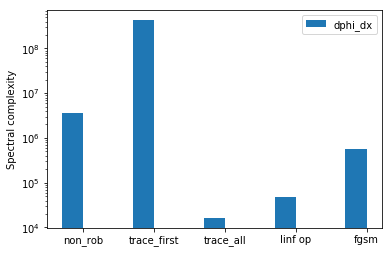

[3587641.1437585237, 424965874.2864362, 16256.970926764248, 47874.3027656854, 567790.6826471635]


In [72]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, spectral_norm_list, width, label='dphi_dx')
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Spectral complexity')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(spectral_norm_list)

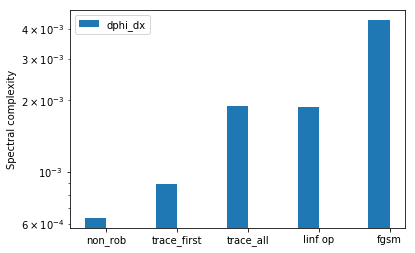

[0.0006372704, 0.0008890634, 0.0018894157, 0.0018820629, 0.004359629]


In [73]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fr_norm_list, width, label='dphi_dx')
#rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Spectral complexity')
#ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(fr_norm_list)

# Accuracies

In [78]:
scope_list = ['model_non_robust']*8
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]

In [88]:
model_list_big = [non_rob_models, trace_first_models, trace_all_models, op_norm_models, adv_trained_models]
sess_list_big = [non_rob_sess_list, sess_trace_first_list, sess_trace_all_list, sess_op_list, adv_train_sess_list]
scope_list = ['model_non_robust', 'model_non_robust', 'model_non_robust', 'model_non_robust', 'model_robust']
labels = ['non_rob', 'trace_first', 'trace_all', 'linf op', 'fgsm']

In [ ]:
def make_acc_vs_eps_plot_error_bars(model_list_big, sess_list_big, eps_list, legend_list, scope_list, pgd = False):
    fig = plt.figure()
    
    for idx, model_list in enumerate(model_list_big):
        sess_list = sess_list_big[idx]
        accs, error_top, error_bottom = acc_versus_eps_single_objective(model_list, sess_list, eps_list, scope_name = scope_list[idx])
        label = legend_list[idx]
        plot.errorbar(eps_list, error_top, error_bottom, label = legend)
    
    return True

In [ ]:
make_acc_vs_eps_plot_error_bars(model_list_big, sess_list_big, eps_list, labels, scope_list)

Model is being evaluated on FGSM data
I0928 15:48:01.584896 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:03.270120 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:05.081174 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:06.493231 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:07.875530 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:09.131503 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:48:10.755514 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0928 15:4

In [84]:
non_rob_accs

[0.9621, 0.4573, 0.1278, 0.0547, 0.0349, 0.028]

In [83]:
trace_first_accs = get_acc_vs_eps(trace_first_models, sess_trace_first_list, eps_list , [None]*8, scope_list, pgd = False)

Model is being evaluated on FGSM data
I0927 09:26:32.688495 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:33.741971 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:34.756202 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:35.747350 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:36.751282 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:37.724618 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:26:39.188182 4424283584 feedforward_robust.py:418] Model is being evaluated on FGSM data
Model is being evaluated on FGSM data
I0927 09:2

<Figure size 432x288 with 0 Axes>

In [ ]:
trace_all_accs = get_acc_vs_eps(trace_first_models, sess_trace_first_list, eps_list , [None]*8, scope_list, pgd = False)

## Distances

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = 2)

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = float("inf"))

## Lipschitzness/ Margins

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]

In [ ]:
reg_evals, adv_evals, margins, dphi_dxs = get_stats_all_models(model_list, sess_list, scope_list)

In [ ]:
#model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model

In [ ]:
reg_evals

In [ ]:
adv_evals

In [ ]:
dphi_dxs

In [ ]:
margins

In [ ]:
labels = ['non robust', 'Sing val all', 'fgsm train', 'hybrid', 'sing val first']

In [ ]:
adv_evals_np = np.array(adv_evals)
acc_adv = adv_evals_np[:, 1]

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/ Gradient means')
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(adv_evals_np[:, 1])

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient means')
ax.set_ylim((0, 1.1))
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


color = 'tab:orange'
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, margins, width, label='margin', color = color)
ax2.set_ylabel('Margins')
ax2.set_ylim((0, 0.40))
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax2.legend(legend_loc = (1.0, 0.8))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (idx, rect) in enumerate(rects1):
        height = rect.get_height()
        height_2 = rects2[idx].get_height() * (1.0/0.37)
        height = max(height, height_2)
        ax.annotate('{:0.3f}'.format(acc_adv[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
print(adv_evals_np[:, 1])

## Accuracies 

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False)

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = True)

## Black box accuracies

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list)

## Singular Values 

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")